## Packages

In [11]:
import pandas as pd
import numpy as np
import logging
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, confusion_matrix, balanced_accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, homogeneity_score, completeness_score
from sklearn.feature_selection import SelectFromModel
import threading
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from joblib import dump, load
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
import warnings

# Filter out specific warning types
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline
np.random.seed(0)
random_state = 42
print_lock = threading.Lock()

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

## Functions: Correct labels, plot images and EDA

In [12]:
def rotateM(x, flip_vertical=False):
    if flip_vertical:
        x = np.flipud(x)
    return np.transpose(np.apply_along_axis(np.flip, 0, x))

def plot_mislabeled_images(indices, data, label, cmap='gray'):
    plt.figure(figsize=(20, 6))
    for idx, i in enumerate(indices):
        plt.subplot(2, 7, idx + 1)
        plt.imshow(rotateM(data.iloc[i, :].values.reshape(64, 64)), cmap=cmap)
        plt.title(label)
    plt.show()

def plot_images(data, labels, label_names, cmap='gray'):
    labels = labels.values.reshape(-1)
    num_rows = 18
    num_cols = 11
    plt.figure(figsize=(30, 30))
    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            animal = label_names[labels[idx]]
            plt.subplot(18, 11, idx + 1)
            plt.imshow(rotateM(data.iloc[idx, :].values.reshape(64, 64)), cmap=cmap)
            plt.title(animal)
    plt.tight_layout()
    plt.show()

def correct_labels(data, true_dogs, true_cats):
    ''' 0 for cats and 1 for dogs'''
    for d in true_dogs:
        data.values[d] = 1
    for c in true_cats:
        data.values[c] = 0
    return data

ssc_mislabeled = [26, 54, 114, 117]
ssd_mislabeled = [8, 37, 112, 151, 176, 177]

In [13]:
def plot_mean_images(x, y):
    ''' Mean Cat and Dog. '''
    cat_indices = np.where(y == 0)[0]  
    dog_indices = np.where(y == 1)[0] 

    mean_cat = np.mean(x.iloc[cat_indices], axis=0)
    mean_dog = np.mean(x.iloc[dog_indices], axis=0)

    mean_cat_image = rotateM(mean_cat.values.reshape(64, 64))
    mean_dog_image = rotateM(mean_dog.values.reshape(64, 64))

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.imshow(mean_cat_image, cmap='gray')
    plt.title('Mean Cat Image')
    plt.subplot(2, 2, 2)
    plt.imshow(mean_dog_image, cmap='gray')
    plt.title('Mean Dog Image')
    plt.show()

In [14]:
def print_label_counts(y):
    num_cats = np.count_nonzero(y == 0)
    num_dogs = np.count_nonzero(y == 1)
    print("Number of cats:", num_cats)
    print("Number of dogs:", num_dogs)

## Models: Constant, objects, splits and grid search

In [15]:
# Random Forest
n_estimators = [15, 50, 100, 150, 250]
max_depth = [None, 3, 5, 10]
# Logistic Regression
penalty = ['l2']
C = [0.01, 0.1, 1, 10]
# KNN
n_neighbors = [3, 5, 7, 10]
cluster_nums = [2, 3, 4, 5, 6, 7, 8, 9, 10]
# SVM
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
C = [0.01, 0.1, 1, 10]
# MLP
hidden_layer_sizes = [(100,), (100, 50), (100, 75, 50)]
activation = []

In [16]:
variance_threshold = VarianceThreshold()
scaler = StandardScaler()

model_map = { 
  'rf': {
    'model': RandomForestClassifier(random_state=random_state, n_jobs=-1),
    'params': {
      'rf__n_estimators': n_estimators,
      'rf__max_depth': max_depth,
    },
    'name': 'Random Forest'
  },
  
  'lr': {
    'model': LogisticRegression(random_state=random_state, n_jobs=-1, solver='lbfgs', max_iter=1000),
    'params': {
      'lr__penalty': penalty,
      'lr__C': C,
    },
    'name': 'Logistic Regression'
  },
  
  'knn': {
    'model': KNeighborsClassifier(n_jobs=-1),
    'params': {
      'knn__n_neighbors': n_neighbors,
    },
    'name': 'K-Nearest Neighbors'
  },
  
  'svm': {
    'model': SVC(random_state=random_state),
    'params': {
      'svm__kernel': kernel,
      'svm__C': C,
    },
    'name': 'Support Vector Machine'
  },
  
  'mlp': {
    # 'model': MLPClassifier(random_state=random_state, max_iter=300, early_stopping=True),
    'model': MLPClassifier(random_state=random_state, early_stopping=True),
    'params': {
      'mlp__hidden_layer_sizes': hidden_layer_sizes,
    },
    'name': 'Multi-Layer Perceptron'
  },
}

In [17]:
def splits(X, Y, test_size=0.2, validation_set=False, validation_size=0.2):
    ''' Split into train and test. Validation size is the percentage of train data that will be validation data. '''
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    
    if validation_set:
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=validation_size, random_state=random_state, stratify=Y_train)
        return X_train, X_val, X_test, Y_train, Y_val, Y_test
    
    return X_train, X_test, Y_train, Y_test

In [18]:
def run_grid_search(X_train, Y_train, model_key, model_info, scoring='accuracy', cv=5):
    best_params = {}
    best_cv_scores = {}
    best_models = {}
    
    print(f"Finding best parameters for model {model_info['name']}...")
    model = model_info['model']
    params = model_info['params']
    
    pipeline = Pipeline([
        # ('variance_threshold', VarianceThreshold()),
        ('scaler', StandardScaler()),
        (model_key, model)
    ])

    # Perform grid search
    grid_search_res = GridSearchCV(pipeline, params, scoring=scoring, cv=cv, n_jobs=-1)
    grid_search_res.fit(X_train, np.ravel(Y_train))
    
    # Save best parameters and score
    best_params['model'] = grid_search_res.best_params_
    best_cv_scores['model'] = grid_search_res.best_score_
    best_models['model'] = grid_search_res.best_estimator_
    
    with print_lock:
        print(f"Best parameters found for {model_info['name']}: {grid_search_res.best_params_}")
        print(f"Best CV {scoring} score: {grid_search_res.best_score_}\n")
    
    return grid_search_res

## Read data set and main processes

In [19]:
# read cats and dogs data
X_cats_dogs = pd.read_csv('../data/CATSnDOGS.csv')
Y_cats_dogs = pd.read_csv('../data/CATSnDOGSlabels.csv')

#plot_mislabeled_images(ssc_mislabeled, X_cats_dogs, label="cat") 
#plot_images(X_cats_dogs, Y_cats_dogs, {0: "cat", 1: "dog"})
#plot_mean_images(X_cats_dogs, Y_cats_dogs)

Y_cats_dogs = correct_labels(Y_cats_dogs, true_dogs = [26, 54, 114, 117], true_cats = [8, 37, 112, 151, 176, 177])
print_label_counts(Y_cats_dogs)

Number of cats: 99
Number of dogs: 99


In [20]:
# Function for confusion matrix
# def confusion_matrix(best_model, model_names, X_test, Y_test):
#     # plot confusion matrix for each model




In [21]:
def process_model(model_key, model_info, X_train, X_test, Y_train, Y_test):
    ''' Best parameters for a given algorithm. '''
    # grid search to get best model/parameters for given algorithm
    best_model = run_grid_search(X_train, Y_train, model_key, model_info)
    logging.info(f'Processing model: {model_info["name"]}')
    
    # metrics on the test data
    test_accuracy = accuracy_score(Y_test, best_model.predict(X_test))
    test_f1_score = f1_score(Y_test, best_model.predict(X_test), average='macro')
    
    # log results
    with print_lock:
        
        logging.info(f'Model: {model_info["name"]}, test accuracy score: {test_accuracy}, test f1 Score: {test_f1_score}')

    # return info
    return {
        'model_key': model_key,
        'model_name': model_info["name"], 
        'grid_search_res': best_model, 
        'test_accuracy': test_accuracy, 
        'test_f1_score': test_f1_score
    }

In [22]:
def main_parallel(model_map):
    results = {} # keys are model keys and values are results dictionaries
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # split dataset
        X_train, X_test, Y_train, Y_test = splits(X_cats_dogs, Y_cats_dogs)
        
        futures = {}
        for model_key, model_info in model_map.items():
            future = executor.submit(process_model, model_key, model_info, X_train, X_test, Y_train, Y_test)
            futures[future] = model_key
        
        for future in concurrent.futures.as_completed(futures):
            model_key = futures[future]
            result = future.result()
            results[model_key] = result
    
    return results

## Part 1 and 2

1.a Comparison of classifiers

In [23]:
results = main_parallel(model_map)

Finding best parameters for model Random Forest...
Finding best parameters for model Logistic Regression...
Finding best parameters for model K-Nearest Neighbors...
Finding best parameters for model Support Vector Machine...
Finding best parameters for model Multi-Layer Perceptron...


2024-05-14 23:41:44,109 - INFO - Processing model: K-Nearest Neighbors


Best parameters found for K-Nearest Neighbors: {'knn__n_neighbors': 7}
Best CV accuracy score: 0.8223790322580646



2024-05-14 23:41:44,788 - INFO - Model: K-Nearest Neighbors, test accuracy score: 0.775, test f1 Score: 0.7714285714285715
2024-05-14 23:41:48,111 - INFO - Processing model: Logistic Regression


Best parameters found for Logistic Regression: {'lr__C': 0.01, 'lr__penalty': 'l2'}
Best CV accuracy score: 0.841733870967742



2024-05-14 23:41:48,335 - INFO - Model: Logistic Regression, test accuracy score: 0.825, test f1 Score: 0.8222222222222222
2024-05-14 23:41:49,381 - INFO - Processing model: Multi-Layer Perceptron
2024-05-14 23:41:49,580 - INFO - Model: Multi-Layer Perceptron, test accuracy score: 0.825, test f1 Score: 0.819471308833011


Best parameters found for Multi-Layer Perceptron: {'mlp__hidden_layer_sizes': (100, 50)}
Best CV accuracy score: 0.8608870967741936



2024-05-14 23:41:51,033 - INFO - Processing model: Support Vector Machine


Best parameters found for Support Vector Machine: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best CV accuracy score: 0.8858870967741936



2024-05-14 23:41:51,240 - INFO - Model: Support Vector Machine, test accuracy score: 0.875, test f1 Score: 0.871050934880722
2024-05-14 23:41:53,387 - INFO - Processing model: Random Forest
2024-05-14 23:41:53,437 - INFO - Model: Random Forest, test accuracy score: 0.85, test f1 Score: 0.84375


Best parameters found for Random Forest: {'rf__max_depth': None, 'rf__n_estimators': 150}
Best CV accuracy score: 0.8288306451612903



In [24]:
# plot confusion matrix for each model
for model_key, result in results.items():
    model_name = result['model_name']
    grid_search_res = result['grid_search_res']
    Y_pred = grid_search_res.predict(X_cats_dogs)
    #cm = confusion_matrix(Y_cats_dogs, Y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['cat', 'dog'])
    disp.plot()
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

NameError: name 'cm' is not defined

In [ ]:
results

{'knn': {'model_key': 'knn',
  'model_name': 'K-Nearest Neighbors',
  'grid_search_res': GridSearchCV(cv=5,
               estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                         ('knn',
                                          KNeighborsClassifier(n_jobs=-1))]),
               n_jobs=-1, param_grid={'knn__n_neighbors': [3, 5, 7, 10]},
               scoring='accuracy'),
  'test_accuracy': 0.775,
  'test_f1_score': 0.7714285714285715},
 'mlp': {'model_key': 'mlp',
  'model_name': 'Multi-Layer Perceptron',
  'grid_search_res': GridSearchCV(cv=5,
               estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                         ('mlp',
                                          MLPClassifier(early_stopping=True,
                                                        random_state=42))]),
               n_jobs=-1,
               param_grid={'mlp__hidden_layer_sizes': [(100,), (100, 50),
                                 

### 1.b Pixel Importance methods

Average of both class:

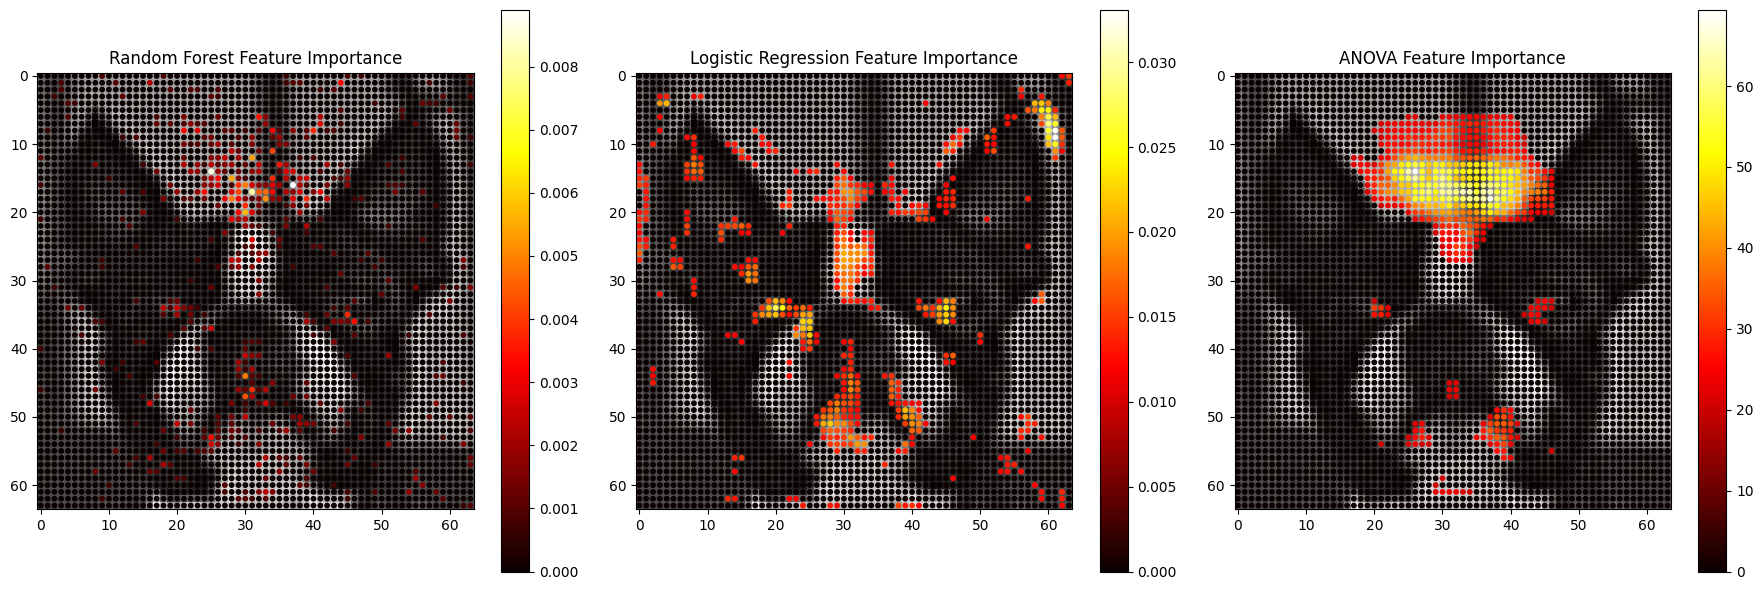

In [59]:
from sklearn.feature_selection import SelectKBest, f_classif


def plot_feature_importance(results, n_best=500):
    feat_importance_lr = []
    feat_importance_rf = []
    feat_importance_anova = []
    
    for model_key, model_info in results.items():
        if model_key == 'rf':
            model = model_info['grid_search_res'].best_estimator_
            feat_importance_rf.append(model.named_steps[model_key].feature_importances_)
        if model_key == 'lr':
            model = model_info['grid_search_res'].best_estimator_
            feat_importance_lr.append(np.abs(model.named_steps[model_key].coef_))
            
    # compute feature importance with anova test
    anova = SelectKBest(score_func=f_classif, k='all')
    anova.fit(X_cats_dogs, Y_cats_dogs.values.ravel())
    
    # Ensure feature importance arrays are flattened and have the correct length
    feat_importance_lr = np.array(feat_importance_lr).flatten()
    feat_importance_rf = np.array(feat_importance_rf).flatten()
    feat_importance_anova = np.array(anova.scores_)
    
    # Function to get top n features and pad the rest with zeros
    def get_top_n_features(importance, n):
        top_indices = np.argsort(importance)[-n:]
        top_importance = np.zeros_like(importance)
        top_importance[top_indices] = importance[top_indices]
        return top_importance
    
    # Get the top n features for each method
    feat_importance_lr = get_top_n_features(feat_importance_lr, n_best)
    feat_importance_rf = get_top_n_features(feat_importance_rf, n_best)
    feat_importance_anova = get_top_n_features(feat_importance_anova, n_best)
        
    # Reshape a test image
    sample_image = rotateM(X_cats_dogs.iloc[100, :].values.reshape(64, 64))

    # Compute the coordinates for each pixel
    coordinates = [(i, j) for i in range(64) for j in range(64)]
    x, y = zip(*coordinates)
    
    # Function to plot feature importances
    def plot_importance(ax, image, importance, title):
        ax.imshow(image, cmap='gray')   
        scatter = ax.scatter(x, y, c=importance, cmap='hot', s=10)
        plt.colorbar(scatter, ax=ax)
        ax.set_title(title)

    # Create subplots
    _, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot feature importances
    plot_importance(axes[0], sample_image, feat_importance_rf, 'Random Forest Feature Importance')
    plot_importance(axes[1], sample_image, feat_importance_lr, 'Logistic Regression Feature Importance')
    plot_importance(axes[2], sample_image, feat_importance_anova, 'ANOVA Feature Importance')
    
    plt.tight_layout()
    plt.show()

plot_feature_importance(results)

Feature importance for cats and dogs separetly:

1.c Clustering

In [26]:
def clustering(X_train, X_test, Y_train, Y_test, cluster_numbers=cluster_nums):
    results = []

    for n_clusters in cluster_numbers:
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels_train = kmeans.fit_predict(X_train)
        cluster_labels_test = kmeans.predict(X_test)

        # Compute homogeneity and completeness for training data
        homogeneity_train = homogeneity_score(Y_train, cluster_labels_train)
        completeness_train = completeness_score(Y_train, cluster_labels_train)
        accuracy_score_train = accuracy_score(Y_train, cluster_labels_train)
        
        # Compute homogeneity and completeness for test data
        homogeneity_test = homogeneity_score(Y_test, cluster_labels_test)
        completeness_test = completeness_score(Y_test, cluster_labels_test)
        accuracy_score_test = accuracy_score(Y_test, cluster_labels_test)
        
        # Align cluster labels with class labels for training data
        aligned_labels_train = np.zeros_like(cluster_labels_train)
        for cluster in range(n_clusters):
            mask = (cluster_labels_train == cluster)
            majority_class = np.bincount(Y_train[mask]).argmax() if np.sum(mask) > 0 else -1  # Majority class in the cluster
            aligned_labels_train[mask] = majority_class
        
        # Recalculate homogeneity and completeness after alignment for training data
        aligned_homogeneity_train = homogeneity_score(Y_train, aligned_labels_train)
        aligned_completeness_train = completeness_score(Y_train, aligned_labels_train)
        accuracy_score_train_aligned = accuracy_score(Y_train, aligned_labels_train)
        
        # Align cluster labels with class labels for test data
        aligned_labels_test = np.zeros_like(cluster_labels_test)
        for cluster in range(n_clusters):
            mask = (cluster_labels_test == cluster)
            majority_class = np.bincount(Y_test[mask]).argmax() if np.sum(mask) > 0 else -1  # Majority class in the cluster
            aligned_labels_test[mask] = majority_class

        # Recalculate homogeneity and completeness after alignment for test data
        aligned_homogeneity_test = homogeneity_score(Y_test, aligned_labels_test)
        aligned_completeness_test = completeness_score(Y_test, aligned_labels_test)
        accuracy_score_test_aligned = accuracy_score(Y_test, aligned_labels_test)
        
        results.append({
            # "Cluster Number": n_clusters,
            # "Train Homogeneity": homogeneity_train,
            # "Train Completeness": completeness_train,
            # "Train Aligned Homogeneity": aligned_homogeneity_train,
            # "Train Aligned Completeness": aligned_completeness_train,
            # "Test Homogeneity": homogeneity_test,
            # "Test Completeness": completeness_test,
            # "Test Aligned Homogeneity": aligned_homogeneity_test,
            # "Test Aligned Completeness": aligned_completeness_test
            "Train Accuracy": accuracy_score_train,
            "Train Aligned Accuracy": accuracy_score_train_aligned,
            "Test Accuracy": accuracy_score_test,
            "Test Aligned Accuracy": accuracy_score_test_aligned
        })
    
    return results

In [27]:
X_train, X_test, Y_train, Y_test = splits(X_cats_dogs, Y_cats_dogs)
clustering(X_train, X_test, np.ravel(Y_train), np.ravel(Y_test), cluster_numbers = cluster_nums)

[{'Train Accuracy': 0.4873417721518987,
  'Train Aligned Accuracy': 0.5316455696202531,
  'Test Accuracy': 0.525,
  'Test Aligned Accuracy': 0.625},
 {'Train Accuracy': 0.45569620253164556,
  'Train Aligned Accuracy': 0.6772151898734177,
  'Test Accuracy': 0.475,
  'Test Aligned Accuracy': 0.725},
 {'Train Accuracy': 0.25949367088607594,
  'Train Aligned Accuracy': 0.7088607594936709,
  'Test Accuracy': 0.325,
  'Test Aligned Accuracy': 0.775},
 {'Train Accuracy': 0.02531645569620253,
  'Train Aligned Accuracy': 0.6518987341772152,
  'Test Accuracy': 0.125,
  'Test Aligned Accuracy': 0.65},
 {'Train Accuracy': 0.11392405063291139,
  'Train Aligned Accuracy': 0.689873417721519,
  'Test Accuracy': 0.05,
  'Test Aligned Accuracy': 0.675},
 {'Train Accuracy': 0.2088607594936709,
  'Train Aligned Accuracy': 0.7721518987341772,
  'Test Accuracy': 0.175,
  'Test Aligned Accuracy': 0.725},
 {'Train Accuracy': 0.056962025316455694,
  'Train Aligned Accuracy': 0.759493670886076,
  'Test Accuracy

2.b Blocks

In [28]:
def blocks_datasets(dataset):
    """ 16 datasets, each representing a block. """
    blocks = []  
    for row in range(4): 
        for col in range(4):  
            # pixel/feature indices corresponding to the block
            block_indices = [] 
            for i in range(64):  
                for j in range(64): 
                    # add the pixel belongs to the current block
                    if (i // 16 == row) and (j // 16 == col):
                        # calculate index of the pixel
                        block_indices.append(i * 64 + j) 
            blocks.append(dataset[:, block_indices])
    return blocks

# plot image and block 
def plot_blocks(dataset, block_dataset):
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 3, 1)
    plt.imshow(rotateM(dataset.iloc[3, :].values.reshape(64, 64)), cmap='gray')
    # define picture
    img = 3
    c = 2
    for i in [1, 2, 3, 4, 5, 6]:
        plt.subplot(2, 3, c)
        plt.imshow(rotateM(block_dataset[i][img].reshape(16, 16)), cmap='gray')
        c = c + 1
    plt.show()

ValueError: num must be an integer with 1 <= num <= 6, not 7

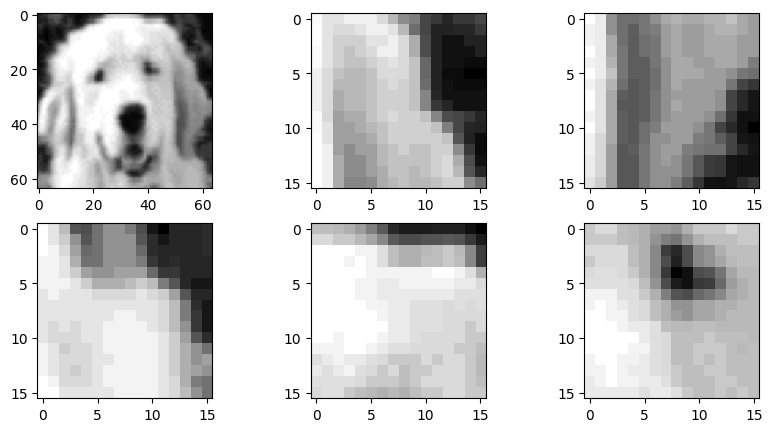

In [29]:
X_cats_dogs_blocks = blocks_datasets(X_cats_dogs.values)
plot_blocks(X_cats_dogs, X_cats_dogs_blocks)

2.c Images upside down

In [ ]:
def flip_half_images_upside_down(X, Y):
    ''' Flip half of the images (reorder columns for half of the dataset).'''
    # cats and dogs random selection
    cat_indices = np.where(Y == 0)[0]
    dog_indices = np.where(Y == 1)[0]
    np.random.shuffle(cat_indices)
    np.random.shuffle(dog_indices)
    # 44 cats and 45 dogs
    cat_indices_to_flip = cat_indices[:44]
    dog_indices_to_flip = dog_indices[:45]

    X_flipped = X.copy()
    # flatten result of flipped images
    for idx in cat_indices_to_flip:
        X_flipped.iloc[idx] = rotateM(X_flipped.iloc[idx].values.reshape(64, 64), flip_vertical=True).flatten()

    for idx in dog_indices_to_flip:
        X_flipped.iloc[idx] = rotateM(X_flipped.iloc[idx].values.reshape(64, 64), flip_vertical=True).flatten()
        
    return X_flipped

In [ ]:
X_cats_dogs_flipped = flip_half_images_upside_down(X_cats_dogs, Y_cats_dogs)

2.e Pixel clustering